## Time Series Forecasting with CNN and Grad-CAM

In [2]:
import numpy as np
import torch
import pandas as pd
import os
from datetime import datetime
import time
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torchvision.datasets.utils import download_and_extract_archive
from torch import nn
from torch.utils.data import Dataset, DataLoader
import shap

colormap = ListedColormap(["#ff595e","#ffca3a","#8ac926","#52a675","#1982c4","#6a4c93"], name="Custom")

plt.rcParams['axes.prop_cycle'] = plt.cycler(color=colormap.colors)
plt.rcParams['axes.axisbelow'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False


In [3]:
csv_filename = "jena_climate_2009_2016.csv"
uri = "https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip"
download_and_extract_archive(url=uri, download_root=os.getcwd(), filename=csv_filename+".zip")

df = pd.read_csv(csv_filename)
# convert 'Date Time' to datetime object
df['Date Time'] = df['Date Time'].apply(lambda x: datetime.strptime(x, "%d.%m.%Y %H:%M:%S"))

# convert angle to cos & sin
df["cos(wd)"] = df["wd (deg)"].apply(lambda x: np.cos(x / 360 * 2 * np.pi))
df["sin(wd)"] = df["wd (deg)"].apply(lambda x: np.sin(x / 360 * 2 * np.pi))

df = df.drop(["wd (deg)"], axis=1)

features = df.columns.values[1:]


display(df)

Using downloaded and verified file: C:\Users\A0663043\OneDrive - ArcelorMittal\Documents\Doktorat AGH\ML_CUDA\jena_climate_2009_2016.csv.zip
Extracting C:\Users\A0663043\OneDrive - ArcelorMittal\Documents\Doktorat AGH\ML_CUDA\jena_climate_2009_2016.csv.zip to C:\Users\A0663043\OneDrive - ArcelorMittal\Documents\Doktorat AGH\ML_CUDA


,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),cos(wd),sin(wd)
0,2009-01-01 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,-0.885394,0.464842
1,2009-01-01 00:20:00,996.57,-8.41,265.01,-9.28,93.40,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,-0.720551,0.693402
2,2009-01-01 00:30:00,996.53,-8.51,264.91,-9.31,93.90,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,-0.989272,0.146083
3,2009-01-01 00:40:00,996.51,-8.31,265.12,-9.07,94.20,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,-0.951057,-0.309017
4,2009-01-01 00:50:00,996.51,-8.27,265.15,-9.04,94.10,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,-0.826098,-0.563526
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420546,2016-12-31 23:20:00,1000.07,-4.05,269.10,-8.13,73.10,4.52,3.30,1.22,2.06,3.30,1292.98,0.67,1.52,-0.500000,-0.866025
420547,2016-12-31 23:30:00,999.93,-3.35,269.81,-8.06,69.71,4.77,3.32,1.44,2.07,3.32,1289.44,1.14,1.92,-0.583541,-0.812084
420548,2016-12-31 23:40:00,999.82,-3.16,270.01,-8.21,67.91,4.84,3.28,1.55,2.05,3.28,1288.39,1.08,2.00,-0.817145,-0.576432
420549,2016-12-31 23:50:00,999.81,-4.23,268.94,-8.53,71.80,4.46,3.20,1.26,1.99,3.20,1293.56,1.49,2.16,-0.697165,-0.716911


p (mbar) has 24 outliers (lower=943.4, upper=1034)
VPmax (mbar) has 58 outliers (lower=-24.87, upper=57.86)
VPdef (mbar) has 1721 outliers (lower=-13.05, upper=27.57)
wv (m/s) has 218 outliers (lower=-5.17, upper=10.76)
max. wv (m/s) has 28 outliers (lower=-8.07, upper=17)


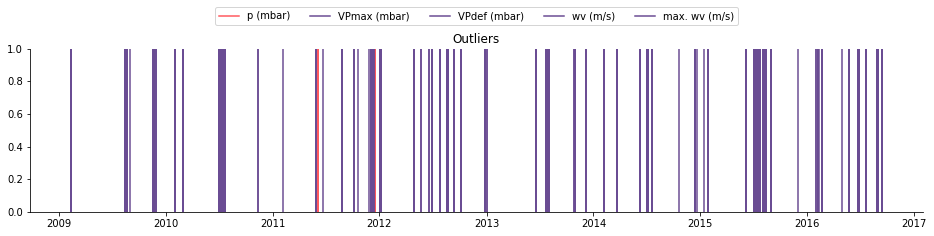

In [4]:
# check for outliers

remove_outliers = True
plot_on_timeseries = True

if plot_on_timeseries:
    fig, ax = plt.subplots(figsize=(16, 3))

for i, X in enumerate(features):
    q05 = df[X].quantile(0.05)
    q95 = df[X].quantile(0.95)
    iqr = df[X].quantile(0.75) - df[X].quantile(0.25)
    
    lower_bound = q05 - 3 * iqr
    upper_bound = q95 + 3 * iqr
    
    outliers = ((df[X] < lower_bound) | (df[X] > upper_bound))

    if outliers.sum() > 0:
        print("%s has %i outliers (lower=%.4g, upper=%.4g)" % (X, outliers.sum(), lower_bound, upper_bound))
    
    if plot_on_timeseries:
        label = X
        for obs in df.loc[outliers, "Date Time"]:
            ax.axvline(x=obs, color=colormap(i), label=label)
            label=None
    
    if remove_outliers:
        df = df[~outliers]
        

if plot_on_timeseries:
    ax.set_title("Outliers")
    ax.legend(bbox_to_anchor=(0.5, 1.2), loc='center', ncol=10)

In [5]:
correlation_matrix = df[features].corr()
redundant_features = []
for i in range(len(features)):
    for j in range(i+1, len(features)):
        col_i = features[i]
        col_j = features[j]
        
        if correlation_matrix.loc[col_i, col_j] > 0.98:
            print("%s and %s are redundant" % (col_i, col_j))
            redundant_features.append(col_j)

df = df.drop(redundant_features, axis=1, errors='ignore')

df = df.set_index("Date Time").resample("H").mean().reset_index()

features = df.columns.values[1:]

T (degC) and Tpot (K) are redundant
VPact (mbar) and sh (g/kg) are redundant
VPact (mbar) and H2OC (mmol/mol) are redundant
sh (g/kg) and H2OC (mmol/mol) are redundant


## Visualization

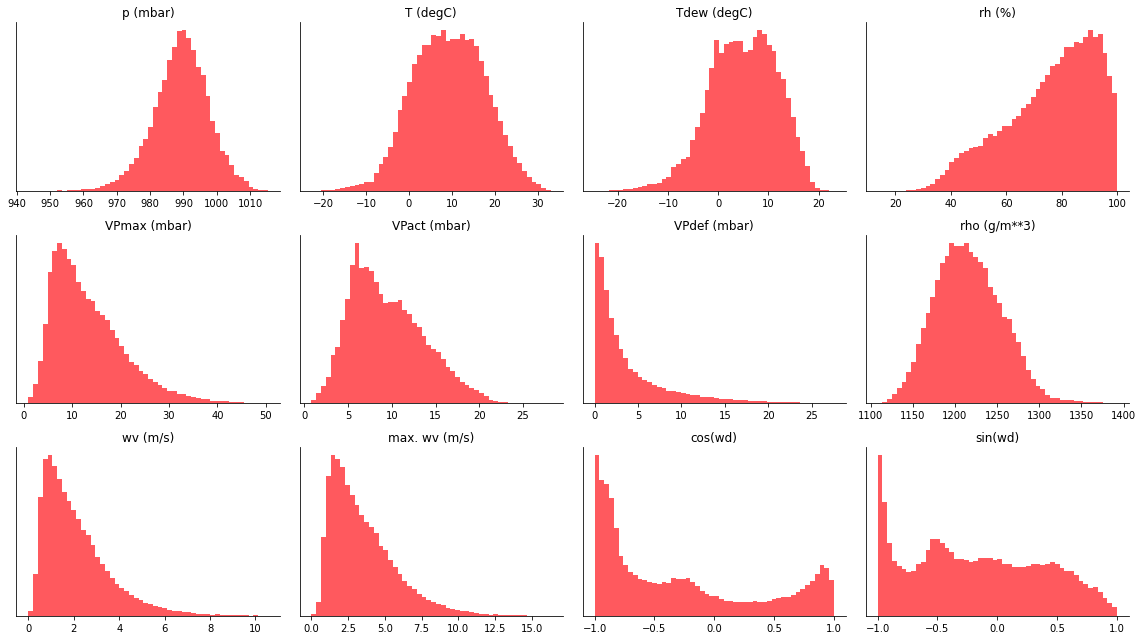

In [6]:
plot_cols = 4
plot_rows = len(features) // plot_cols + min(len(features) % plot_cols, 1)

fig, axes = plt.subplots(figsize=(16, 3 * plot_rows), nrows=plot_rows, ncols=plot_cols)

for ax, X in zip(axes.flatten(), features):
    ax.set_title(X)
    ax.hist(df[X], bins=50)
    ax.set_yticks([])

fig.tight_layout()

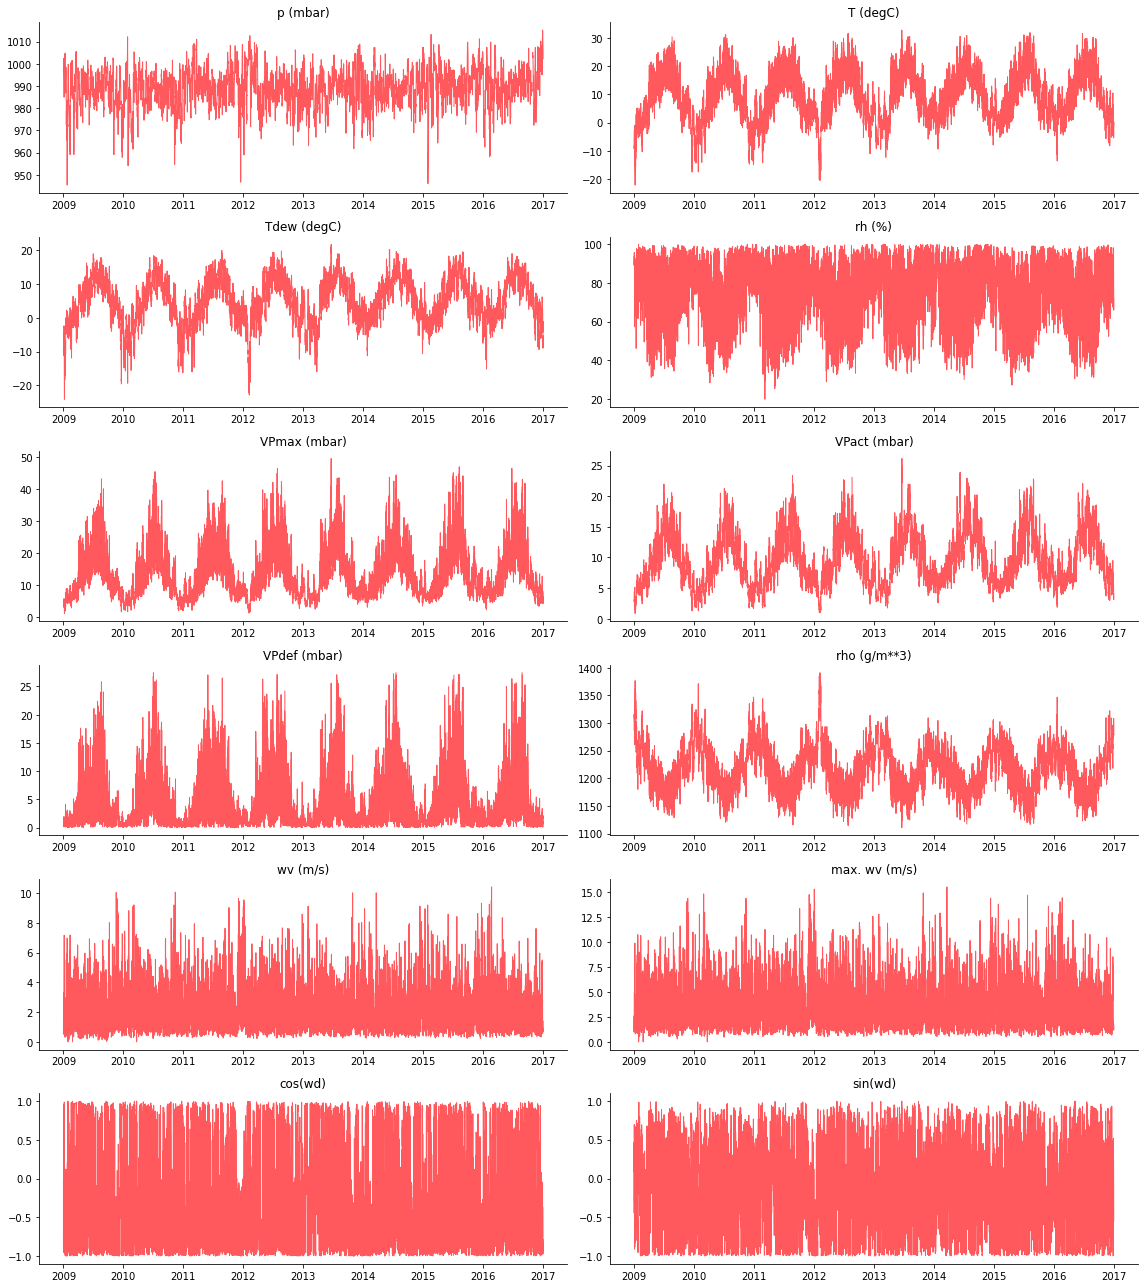

In [7]:
plot_cols = 2
plot_rows = len(features) // plot_cols + min(len(features) % plot_cols, 1)

fig, axes = plt.subplots(figsize=(16, 3 * plot_rows), nrows=plot_rows, ncols=plot_cols)

sample_low = 0
sample_high = 52560 * 2 # 2 years
sample_high = -1
skip = 6

for ax, X in zip(axes.flatten(), features):
    ax.set_title(X)
    plot_x = df["Date Time"].iloc[sample_low:sample_high:skip]
    plot_y = df[X].iloc[sample_low:sample_high:skip]
    ax.plot(plot_x, plot_y, linewidth=1)

fig.tight_layout()

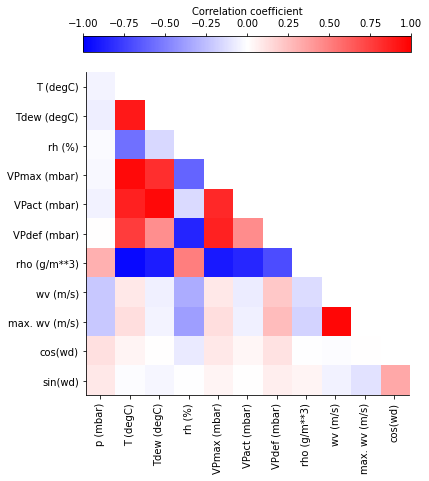

In [8]:
correlation_matrix = df.corr()

for i in range(len(features)):
    for j in range(len(features)):
        if i<=j:
            correlation_matrix.iloc[i, j] = np.nan

plt.figure(figsize=(8, 7))
plt.imshow(correlation_matrix, cmap="bwr", vmin=-1, vmax=1)
plt.colorbar(label="Correlation coefficient", location="top", shrink=0.6)
plt.xticks(ticks=range(len(features)), labels=features, rotation=90)
plt.yticks(ticks=range(len(features)), labels=features, rotation=0)
plt.xlim(-0.5, len(features) - 1.5 )
plt.ylim(len(features)-0.5, 0.5 )
plt.tight_layout()
plt.show()

## Split, scale & transform

In [9]:
hours_future = 12
hours_past = 48

time_array = df['Date Time']
X = df[features]
y = df['T (degC)'].shift(-(hours_future + hours_past))

# split into test and train datasets
time_train, time_test, X_train, X_test, y_train, y_test = train_test_split(time_array, X, y, test_size=0.3, shuffle=False)

# scale datasets
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# switch from pandas Series to numpy array
y_train = y_train.values
y_test = y_test.values

#### Prepare data for PyTorch

In [10]:
def prepare_sequences(X, sequence_length=48):
    X_seq = []
    for i in range(sequence_length):
        X_roll = X.roll(-i, dims=0)
        X_seq.append(X_roll)
    
    X_seq = torch.stack(X_seq, dim=2)
    
    # expand the dimensions
    X_seq = X_seq[:, None, :, :]
    
    return X_seq


def prepare_data(X, y, time_array, hours_past=48, hours_future=12, batch_size=32):
    X = torch.Tensor(X)
    y = torch.Tensor(y)
    
    X_ts = prepare_sequences(X, hours_past)
    X_ts = X_ts[:-(hours_past + hours_future)]
    y_ts = y[:-(hours_past + hours_future)]
        
    time_array = time_array[:-(hours_past + hours_future)]
    
    # we verify which observations are valid i.e. there is proper time difference between the observations
    # valid_observations = ((time_array.diff(-hours_past).dt.total_seconds() / 3600 ) ==  -hours_past ) & ((time_array.diff(hours_future).dt.total_seconds() / 3600 ) ==  hours_future )
    
    x_nan_observations = torch.isnan(X_ts).any(dim=1).any(dim=1).any(dim=1)
    y_nan_observations = torch.isnan(y_ts)
    
    nan_observations = x_nan_observations | y_nan_observations
    
    time_ts = time_array[~nan_observations.numpy()]
    X_ts = X_ts[~nan_observations]
    y_ts = y_ts[~nan_observations]
    
    return time_ts, X_ts, y_ts

time_ts_train, X_ts_train, y_ts_train = prepare_data(X_train, y_train, time_train)
time_ts_test, X_ts_test, y_ts_test = prepare_data(X_test, y_test, time_test)

In [11]:
class WeatherDataset(Dataset):
    def __init__(self,features, target):
        self.features = features
        self.target = target
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self,idx):
        item = self.features[idx]
        label = self.target[idx]
        
        return item,label
    
train = WeatherDataset(X_ts_train, y_ts_train)
test = WeatherDataset(X_ts_test, y_ts_test)

train_loader = DataLoader(train, batch_size=64, shuffle=False)
test_loader = DataLoader(test, batch_size=64, shuffle=False)

## Build model and train

In [12]:
class CNN_GradCAM(nn.Module):
    def __init__(self, input_shape):
        super().__init__()
                
        self.conv1 = nn.Conv2d(1, 16, kernel_size=(1, 3))
        self.conv2 = nn.Conv2d(16, 32, kernel_size=(1, 3))
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=(1, 2))
        
        flat_size = int((input_shape[-1] - 4 * 2) / 4 * 32 * input_shape[-2])
        self.flat = nn.Flatten()
        self.fc1 = nn.Linear(flat_size, 50)
        self.fc2 = nn.Linear(50, 1)
        
        # placeholder for the gradients
        self.gradients = None
    
    def forward(self, x):
        # 1st convolution
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        
        # 2nd convolution
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        
        # flatten & fully connected layers
        x = self.flat(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)

        return x
    
    def forward_cam(self, x):
        # 1st convolution
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        
        # 2nd convolution
        x = self.conv2(x)
        x = self.relu(x)
        h = x.register_hook(self.activations_hook)
        x = self.pool(x)
        
        # flatten & fully connected layers
        x = self.flat(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        
        return x
        
    # hook for the gradients of the activations
    def activations_hook(self, grad):
        self.gradients = grad
        
    
    # method for the gradient extraction
    def get_activations_gradient(self):
        return self.gradients
    
    # method for the activation exctraction
    def get_activations(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.relu(x)
        return x
    
device = torch.device("cpu")
model = CNN_GradCAM(X_ts_train.shape).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
loss_function = nn.MSELoss()

In [13]:
def fit(model, data_loader):
    running_loss = .0
    model.train()
    
    for idx, (inputs, labels) in tqdm(enumerate(data_loader), total=data_loader.__len__(), disable=True):
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        preds = model(inputs.float())[:, 0]
        
        loss = loss_function(preds ,labels)
        loss.backward()
        optimizer.step()
        running_loss += loss
        
    train_loss = running_loss/len(data_loader)
    train_loss = train_loss.detach().numpy()
    return train_loss

def validate(model, data_loader):
    running_loss = .0
    model.eval()
    
    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(data_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            preds = model(inputs.float())[:, 0]
            loss = loss_function(preds,labels)
            running_loss += loss
            
        valid_loss = running_loss/len(data_loader)
        valid_loss = valid_loss.detach().numpy()
        
        return valid_loss

train_losses = []
valid_losses = []

# training settings
epochs = 25
min_loss_increase = 1e-1
epochs_wait_max = 3
epochs_wait = 0
current_loss = 1e6

print("Started learning for %i epochs..." % epochs)
for epoch in range(epochs):
    start = time.time()
    train_loss = fit(model, train_loader)
    train_losses.append(train_loss)
    valid_loss = validate(model, test_loader)
    valid_losses.append(valid_loss)
    time_elapsed = time.time() - start
    
    print('Epochs %i/%i (%.3g seconds)\n    Train loss = %.3g \n    Valid loss = %.3g' % (epoch+1, epochs, time_elapsed, train_loss, valid_loss))
    
    if (current_loss - valid_loss) < min_loss_increase:
        epochs_wait +=1
    else:
        current_loss = valid_loss
        epochs_wait = 0
        
    if epochs_wait == epochs_wait_max:
        print("Not enough progress in last %i epochs, end of training." % epochs_wait_max)
        break
        

Started learning for 25 epochs...
Epochs 1/25 (30.5 seconds)
    Train loss = 111 
    Valid loss = 65.5
Epochs 2/25 (32.2 seconds)
    Train loss = 59.4 
    Valid loss = 34.1
Epochs 3/25 (27.1 seconds)
    Train loss = 34.9 
    Valid loss = 19.5
Epochs 4/25 (27.8 seconds)
    Train loss = 20.5 
    Valid loss = 14.4
Epochs 5/25 (26.4 seconds)
    Train loss = 15.7 
    Valid loss = 13.2
Epochs 6/25 (25.1 seconds)
    Train loss = 14.2 
    Valid loss = 12.4
Epochs 7/25 (24.9 seconds)
    Train loss = 13.2 
    Valid loss = 11.8
Epochs 8/25 (24.1 seconds)
    Train loss = 12.5 
    Valid loss = 11.4
Epochs 9/25 (23.8 seconds)
    Train loss = 12 
    Valid loss = 11.1
Epochs 10/25 (23.8 seconds)
    Train loss = 11.6 
    Valid loss = 10.8
Epochs 11/25 (24.1 seconds)
    Train loss = 11.3 
    Valid loss = 10.6
Epochs 12/25 (22.2 seconds)
    Train loss = 11.1 
    Valid loss = 10.5
Epochs 13/25 (22.7 seconds)
    Train loss = 10.8 
    Valid loss = 10.3
Epochs 14/25 (22.8 seconds)
 

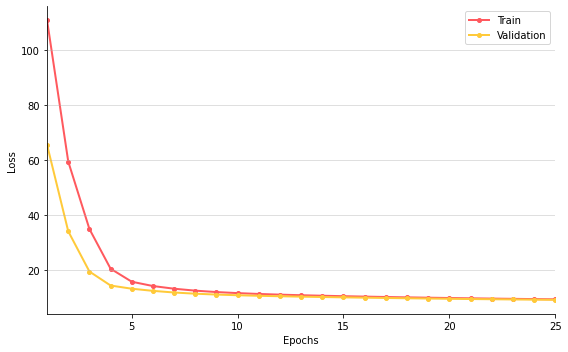

In [14]:
fig, ax = plt.subplots(figsize=(8, 5))
epochs_passed = len(train_losses)
ax.plot(range(1, epochs_passed + 1), train_losses, label="Train", linewidth=2, marker='o', markersize=4)
ax.plot(range(1, epochs_passed + 1), valid_losses, label="Validation", linewidth=2, marker='o', markersize=4)
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax.set_xlim(1, len(train_losses))
ax.legend()
ax.grid(axis='y', alpha=0.5)
fig.tight_layout()

## Predict and evaluate

In [15]:
def r2_score(y, y_pred):
    ss_tot = torch.sum((y - torch.mean(y)) ** 2)
    ss_res = torch.sum((y - y_pred) ** 2)
    return 1 - ss_res / ss_tot

time_ts_test_sample = time_ts_test[::5]
X_ts_test_sample = X_ts_test[::5]
y_ts_test_sample = y_ts_test[::5]

y_test_pred = model.forward(X_ts_test_sample).detach().view(-1)

print("R2 score: %.3f" % r2_score(y_ts_test_sample, y_test_pred))

R2 score: 0.832


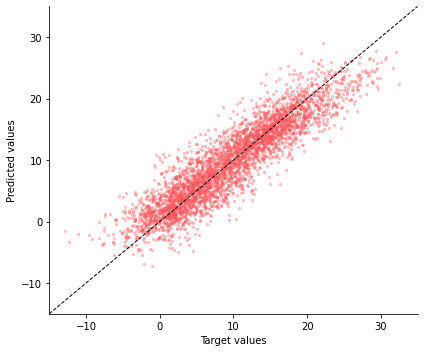

In [16]:
fig, ax = plt.subplots(figsize=(6, 5))
ax.scatter(y_ts_test_sample, y_test_pred, s=5, alpha=0.3)
ax.plot([-15, 35], [-15, 35], linewidth=1, color="black", linestyle="--")
ax.set_xlim(-15, 35)
ax.set_ylim(-15, 35)
ax.set_xlabel("Target values")
ax.set_ylabel("Predicted values")
fig.tight_layout()


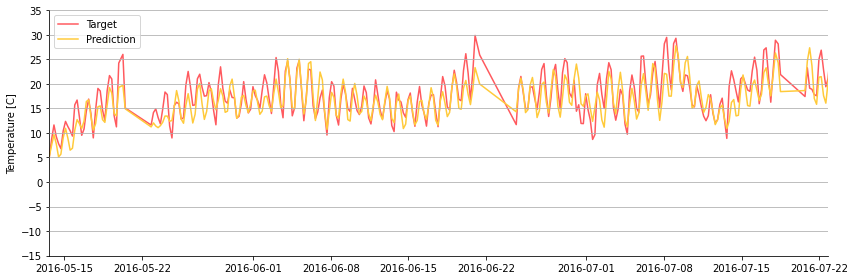

In [17]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(time_ts_test_sample, y_ts_test_sample, label="Target")
ax.plot(time_ts_test_sample, y_test_pred, label="Prediction", alpha=1, linewidth=1.5)
ax.set_ylabel("Temperature [C]")
ax.legend()
ax.set_xlim(time_ts_test_sample.values[-1000], time_ts_test_sample.values[-700])
ax.set_yticks(np.arange(-15, 35.1, 5))
ax.grid(axis='y')
fig.tight_layout()

### Grad-CAM

In [18]:
# references
# https://github.com/jacobgil/pytorch-grad-cam/issues/233
# https://medium.com/@stepanulyanin/implementing-grad-cam-in-pytorch-ea0937c31e82
# https://arxiv.org/pdf/2001.07582.pdf

In [35]:
def reshape_transform(tensor, target_size):
    """ 
    Transforms a tensor to the required shape by interpolation
    Used to transform the tensor before last pooling layer to input size.
    Note: this should only interpolate time axis, not the feature axis!
    """
    tensor = tensor.reshape((1, 1, tensor.shape[0], tensor.shape[1]))
    image_with_single_row = tensor[:, None, :, :]
    # Lets make the time series into an image with 16 rows for easier visualization on screen later
    return torch.nn.functional.interpolate(tensor, target_size, mode='bilinear')

def genereate_gradcam_explanation(model, x):
    pred = model.forward_cam(x)
    pred.backward()
    gradients = model.get_activations_gradient()
    # print("Gradients shape: {}".format(gradients.shape))
    
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
    
    # print("Pooled Gradients shape: {}".format(pooled_gradients.shape))
    
    activations = model.get_activations(x).detach()
    # print("Activations shape: {}".format(activations.shape))

    for i in range(activations.shape[1]):
        activations[:, i, :, :] *= pooled_gradients[i]

    mean_activations = torch.mean(activations, dim=1).squeeze()
    mean_activations = torch.maximum(mean_activations, torch.tensor(0))
    mean_activations = reshape_transform(mean_activations, (x.shape[-2], x.shape[-1]))
    return mean_activations


def plot_explanation_heatmap(x, explanation):
    """
    Function to plot explanation heatmap
    """        
    t = explanation.shape[-1] -1 # time 
    
    fig, ax =plt.subplots(figsize=(8, 4))
    colormap_values = ax.imshow(x.squeeze(), aspect=2, vmin=None, vmax=None, cmap="Reds")
    plt.colorbar(colormap_values, shrink=0.65, label="Normalized Values", location="top", aspect=30)
    ax.set_xlabel("Time back [h]")
    ax.set_yticks(range(12))
    ax.set_yticklabels(features)
    ax.set_xticks(np.linspace(0, t, 8).astype(int))
    ax.set_xticklabels(np.linspace(t, 0, 8).astype(int))
    fig.tight_layout()
    
    fig, ax =plt.subplots(figsize=(8, 4))
    colormap_activations = ax.imshow(explanation.squeeze(), aspect=2, vmin=None, vmax=None, cmap="Reds")
    plt.colorbar(colormap_activations, shrink=0.65, label="Activations", location="top", aspect=30)
    ax.set_xlabel("Time back [h]")
    ax.set_yticks(range(12))
    ax.set_yticklabels(features)
    ax.set_xticks(np.linspace(0, t, 8).astype(int))
    ax.set_xticklabels(np.linspace(t, 0, 8).astype(int))
    fig.tight_layout()

In [20]:
# batch of data for explanations
x_batch, y_batch = next(iter(test_loader))

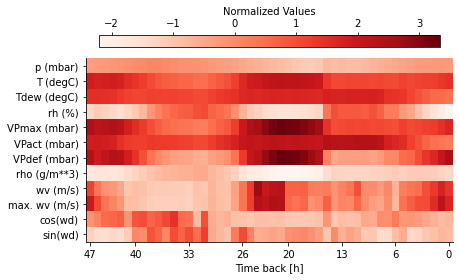

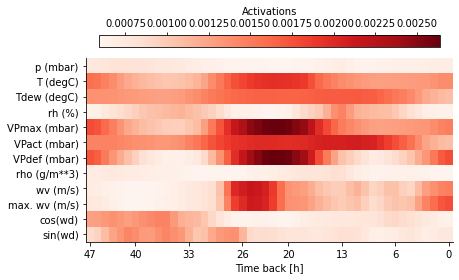

In [36]:
i = 28 # select one observation from batch
x = x_batch[i:i+1]
y = y_batch[i:i+1]

explanation = genereate_gradcam_explanation(model, x)
plot_explanation_heatmap(x, explanation)

### SHAP 

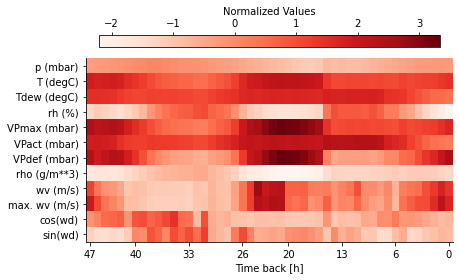

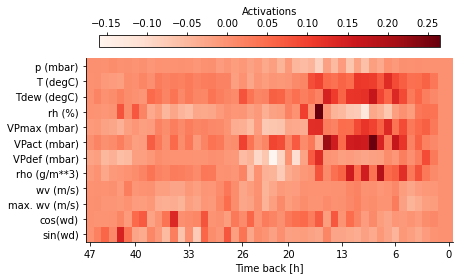

In [37]:
from shap import GradientExplainer
grad_explainer = GradientExplainer(model, X_ts_test)
x_shap_values = grad_explainer.shap_values(x)

plot_explanation_heatmap(x, x_shap_values)